In [75]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import os

## tf versão 2.0.0
##keras versão 2.3.1


In [76]:
 
### Parâmetros
path = "../"
batch_size_val=50
steps_per_epoch_val=100
epochs_val=10
imageDimesions = (60,60,3)


## Importar Imagens
count = 0
images = []
classNo = []
pastas = os.listdir(path)
print("Total de Classes:",len(pastas))
noOfClasses=3


Total de Classes: 1


In [77]:
batch_size = 32
img_width, img_height = 60, 60
train_path = "../../datasets/COVID-19_Radiography_Dataset/"
images = []
labels = []

directory = ["COVID", "Normal", "Pneumonia"]
for index,folder in enumerate(directory):
        for image in os.listdir(os.path.join(train_path,folder,'images')):
                # print(os.path.join(train_path, folder,image).replace("\\","/"))
                img = cv2.imread(os.path.join(train_path, folder,'images',image).replace("\\","/"))
                img = cv2.resize(img,(img_width,img_height))
                mask = cv2.imread(os.path.join(train_path, folder,'masks',image), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask,(img_width,img_height))
                masked_image = cv2.bitwise_and(img, img, mask=mask)
                images.append(masked_image)
                labels.append(index)

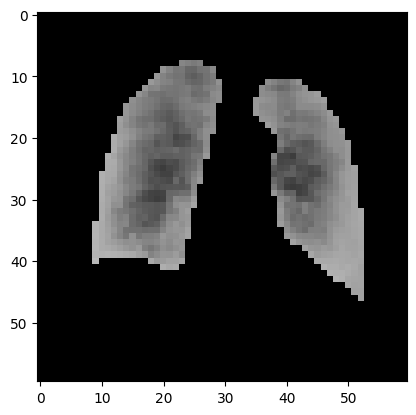

In [78]:
plt.imshow(images[0])
plt.show()

In [79]:


images = np.array(images)
classNo = np.array(labels)

## Separando Imagens
X_train, X_test_pre, y_train, y_test_pre = train_test_split(images, classNo, test_size=0.2)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

## Funções do pré-processamento das Imagens
def grayscale(img):
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    return img
def equalize(img):
    img =cv2.equalizeHist(img)
    return img
def preprocessing(img):
    img = grayscale(img)     # Converter em Gray
    # img = equalize(img)      # Padronizar a Luminosidade das imagens
    img = img/255            # normalizar valores para 0 e 1 em vez de 0 e 255
    return img

## Pré-processar imagens
X_train=np.array(list(map(preprocessing,X_train)))
X_validation=np.array(list(map(preprocessing,X_validation)))
X_test=np.array(list(map(preprocessing,X_test_pre)))
 
## Regularizar Arrays
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_validation=X_validation.reshape(X_validation.shape[0],X_validation.shape[1],X_validation.shape[2],1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

print(len(X_train))

9697


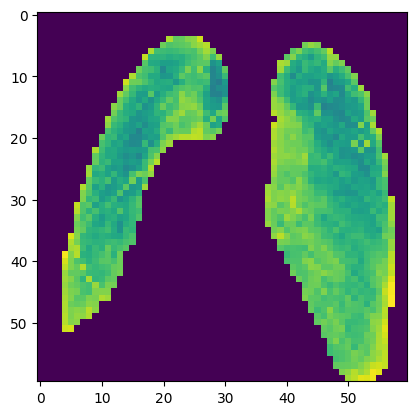

array([0, 1, 1, ..., 1, 1, 1])

In [80]:
plt.imshow(X_train[0])
plt.show()
y_train

In [81]:

## Aumentando Imagens com ImageDataGenerator
dataGen= ImageDataGenerator(width_shift_range=0.1,   # alterar posição width da imagem
                            height_shift_range=0.1,  # alterar posição hight da imagem
                            zoom_range=0.2,  # colocar zoom
                            shear_range=0.1,  # mudar ângulo
                            rotation_range=10)  # rotacionar imagem
dataGen.fit(X_train)
# batches= dataGen.flow(X_train,y_train,batch_size=batch_size_val)
# X_batch,y_batch = next(batches)

y_train = to_categorical(y_train,noOfClasses)
y_validation = to_categorical(y_validation,noOfClasses)
y_test = to_categorical(y_test_pre,noOfClasses)

In [65]:
y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [66]:

## Criar Modelo
def myModel():
    model= Sequential()
    model.add(Conv2D(32,kernel_size=(5,5),input_shape=(imageDimesions[0],imageDimesions[1],1),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,kernel_size=(3,3),activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(128,activation='relu'))
    model.add(Dense(noOfClasses,activation='softmax'))

    # COMPILE MODEL
    model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    return model


In [67]:
model = myModel()
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 56, 56, 32)        832       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 28, 28, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 13, 13, 64)       0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 flatten_6 (Flatten)         (None, 10816)            

In [68]:

## Treinamento

history=model.fit(X_train,y_train,steps_per_epoch=steps_per_epoch_val,epochs=epochs_val,validation_data=(X_validation,y_validation),shuffle=1)


Epoch 1/10
100/100 [==============================] - 21s 201ms/step - loss: 0.5738 - accuracy: 0.7470 - val_loss: 0.4207 - val_accuracy: 0.8256
Epoch 2/10
100/100 [==============================] - 20s 198ms/step - loss: 0.4243 - accuracy: 0.8184 - val_loss: 0.3778 - val_accuracy: 0.8404
Epoch 3/10
100/100 [==============================] - 20s 200ms/step - loss: 0.3777 - accuracy: 0.8382 - val_loss: 0.3525 - val_accuracy: 0.8458
Epoch 4/10
100/100 [==============================] - 20s 200ms/step - loss: 0.3518 - accuracy: 0.8460 - val_loss: 0.3511 - val_accuracy: 0.8548
Epoch 5/10
100/100 [==============================] - 20s 202ms/step - loss: 0.3428 - accuracy: 0.8538 - val_loss: 0.3389 - val_accuracy: 0.8536
Epoch 6/10
100/100 [==============================] - 20s 202ms/step - loss: 0.3198 - accuracy: 0.8636 - val_loss: 0.3167 - val_accuracy: 0.8565
Epoch 7/10
100/100 [==============================] - 20s 203ms/step - loss: 0.3065 - accuracy: 0.8691 - val_loss: 0.3105 - val_ac

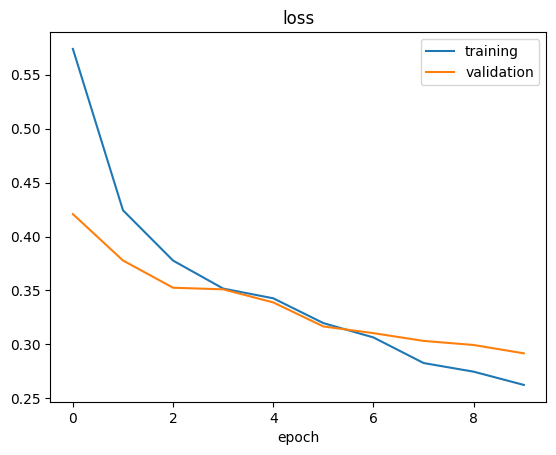

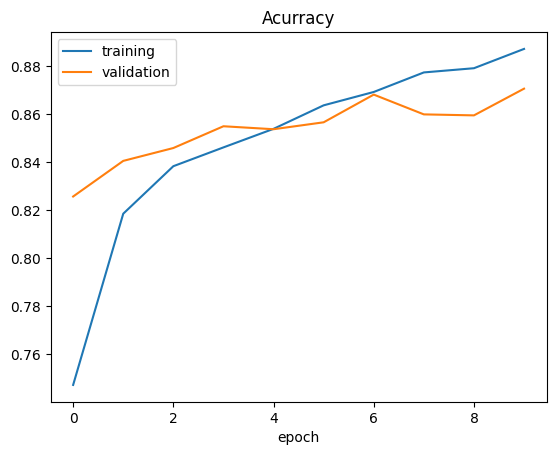

Test Score: 0.31557053327560425
Test Accuracy: 0.8650610446929932


In [69]:

## Mostrar histórico de treinamento
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training','validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score =model.evaluate(X_test,y_test,verbose=0)
print('Test Score:',score[0])
print('Test Accuracy:',score[1])

In [70]:

## Salvar modelo
model.save('modelo.h5')
print('Modelo Salvo!')

Modelo Salvo!


95/95 [==============================] - 2s 19ms/step


ValueError: num must be an integer with 1 <= num <= 10, not 11

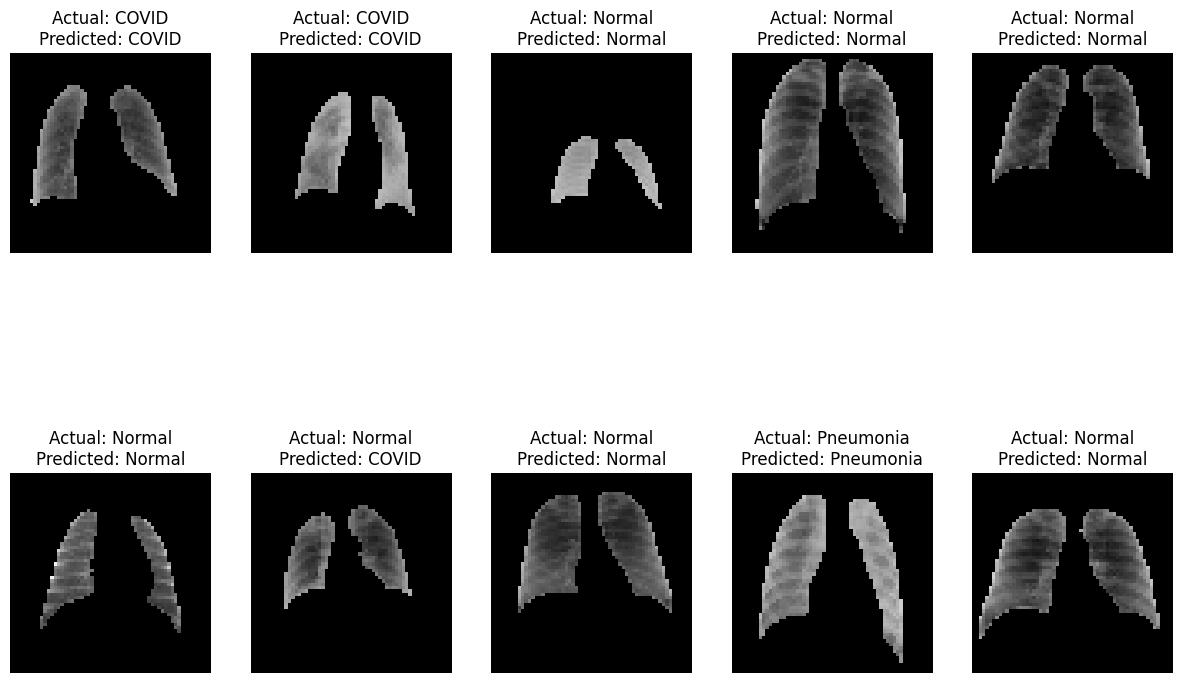

In [85]:
# Obter previsões usando o modelo
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

# Plotar resultados
plt.figure(figsize=(15, 10))
for i in range(len(X_test_pre)):
    plt.subplot(2, 5, 1)
    plt.imshow(X_test_pre[i])
    plt.title(f'Actual: {directory[y_test_pre[i]]}\nPredicted: {directory[predicted_classes[i]]}')
    plt.axis('off')
plt.tight_layout()
plt.show()